In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score

r2score = R2Score()

torch.manual_seed(2)
np.random.seed(2)
torch.set_printoptions(precision=8)

In [2]:
# Sigma function for conditioning (u1 --> y1, u2 --> y2, ...)
def sigma(t, k, n):                             # t is the input, k is the size of one control, n is the window length
    a = np.array([])
    for i in range(n):
        for j in range(k):
            a = np.append(a, i+1)
    a = torch.tensor(a, dtype=torch.float32)
    alpha = 16
    return 1 - torch.sigmoid(alpha*(a-t-1.5))

In [3]:
# Model
class Net(torch.nn.Module):
  def __init__(self, n=4, p=8, noi=1):
    super(Net, self).__init__()
    self.n   = n                    # horizon window length
    self.p   = p                    # size of branch and trunk output
    self.noi = noi                  # number of input
    self.k   = int(self.p/self.n)   # size of each sub-branch
    
    # Branch x0
    self.input_x0  = torch.nn.Linear(1, 8)
    self.hidden_x0 = torch.nn.Linear(8, 8)
    self.output_x0 = torch.nn.Linear(8, self.p)

    # Branch 1 u
    self.input1_u  = torch.nn.Linear(self.noi, 2)
    self.hidden1_u = torch.nn.Linear(2, 2)
    self.output1_u = torch.nn.Linear(2, self.k)

    # Branch 2 u
    self.input2_u  = torch.nn.Linear(self.noi, 2)
    self.hidden2_u = torch.nn.Linear(2, 2)
    self.output2_u = torch.nn.Linear(2, self.k)

    # Branch 3 u
    self.input3_u  = torch.nn.Linear(self.noi, 2)
    self.hidden3_u = torch.nn.Linear(2, 2)
    self.output3_u = torch.nn.Linear(2, self.k)

    # Branch 4 u
    self.input4_u  = torch.nn.Linear(self.noi, 2)
    self.hidden4_u = torch.nn.Linear(2, 2)
    self.output4_u = torch.nn.Linear(2, self.k)

    # Trunk
    self.input_t   = torch.nn.Linear(1, 8)
    self.hidden_t  = torch.nn.Linear(8, 8)
    self.output_t  = torch.nn.Linear(8, self.p)

  def forward(self, x0, u, t):
    # h
    h = torch.selu(self.input_x0(x0))
    h = torch.selu(self.hidden_x0(h))
    h = self.output_x0(h)

    # f
    f1 = torch.selu(self.input1_u(u[:,0*self.noi:1*self.noi].reshape(-1,self.noi)))
    f1 = torch.selu(self.hidden1_u(f1))
    f1 = self.output1_u(f1)

    f2 = torch.selu(self.input2_u(u[:,1*self.noi:2*self.noi].reshape(-1,self.noi)))
    f2 = torch.selu(self.hidden2_u(f2))
    f2 = self.output2_u(f2)

    f3 = torch.selu(self.input3_u(u[:,2*self.noi:3*self.noi].reshape(-1,self.noi)))
    f3 = torch.selu(self.hidden3_u(f3))
    f3 = self.output3_u(f3)

    f4 = torch.selu(self.input4_u(u[:,3*self.noi:4*self.noi].reshape(-1,self.noi)))
    f4 = torch.selu(self.hidden4_u(f4))
    f4 = self.output4_u(f4)

    f = torch.cat((f1, f2, f3, f4), dim=1)

    # sigma
    s = sigma(t, self.k, self.n)

    # g
    g = torch.selu(self.input_t(t))
    g = torch.selu(self.hidden_t(g))
    g = self.output_t(g)

    return torch.sum(h*f*s*g + x0, dim=1).reshape(-1,1)

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x0_data, testset.u_data, testset.t_data)

    r2 = r2score(pred_Y, testset.y_data)
    return r2.item()

In [5]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, n, H, noi):
    self.n   = n                                  # horizon length
    self.H   = H                                  # max window length
    self.noi = noi                                # number of input
    self.src_file = src_file                      # source file
    df = pd.read_csv(self.src_file, header=None)

    X0, U, T, Y = np.array([[1]], dtype=np.float32), np.ones((1, n*self.noi)), np.array([[1]], dtype=np.float32), np.array([[1]], dtype=np.float32)
    for i in range(df.shape[0]):
        row = np.array(df.iloc[i])
        for j in range(self.H - self.n):
            x0 = np.array([[row[self.H*self.noi + j]]])
            u  = np.array([row[j:j + self.n*self.noi]])
            for t in range(1, self.n + 1):
                y = np.array([[row[self.H*self.noi + j + t]]])
                t = np.array([[t]])

                X0 = np.concatenate((X0, x0))
                U  = np.concatenate((U, u))
                T  = np.concatenate((T, t))
                Y  = np.concatenate((Y, y))

    X0, U, T, Y = X0[1:], U[1:], T[1:], Y[1:]

    self.x0_data = torch.tensor(X0, dtype=torch.float32)
    self.u_data  = torch.tensor(U,  dtype=torch.float32)
    self.t_data  = torch.tensor(T,  dtype=torch.float32)
    self.y_data  = torch.tensor(Y,  dtype=torch.float32)

  def __len__(self):
    return len(self.x0_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x0  = self.x0_data[idx]
    u   = self.u_data[idx]
    t   = self.t_data[idx]
    y   = self.y_data[idx]
    sample = {'x0':x0, 'u':u, 't':t, 'y':y}
    return sample

In [6]:
# Early stopping
def early_stop(list, min_epochs, patience):
    if(len(list) > min_epochs):
        if(np.max(list[-patience:]) < 1.0001*np.max(list[0: -patience])):
            return 1
    return 0

In [7]:
# Plot
def plot(net, dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x0_data, dataset.u_data, dataset.t_data)

    plt.figure(figsize=size)
    plt.plot(dataset.y_data[0::4], 'b',   label=r'real',      linewidth=3)
    plt.plot(pred_Y[0::4],         'r--', label=r'predicted', linewidth=1)
    plt.ylabel(r'x(t)')
    plt.legend()
    plt.show()

In [8]:
# Train function
def train(net, train_ds, test_ds, lr=0.001, min_epochs=200, max_epochs=100000, patience=100):
    loss_func  = torch.nn.MSELoss()
    optimizer  = torch.optim.Adam(net.parameters(), lr=lr)

    train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=train_ds.y_data.shape[0], shuffle=True)

    R2_train = np.array([])
    R2_test  = np.array([])
    for epoch in range(0, max_epochs+1):
        net.train()
        loss  = 0
        count = 0
        for (_, batch) in enumerate(train_ldr):
            X0 = batch['x0']
            U  = batch['u']
            T  = batch['t']
            Y  = batch['y']

            optimizer.zero_grad()
            output = net(X0, U, T)             # compute the output of the Network
            loss_val = loss_func(output, Y)    # loss function
            loss += loss_val.item()            # accumulate
            loss_val.backward()                # gradients
            optimizer.step()                   # update paramters
            count += 1
        
        net.eval()
        R2_train = np.append(R2_train, eval(net, train_ds))
        R2_test  = np.append(R2_test, eval(net, test_ds))

        if(epoch%100==0):
            print("epoch = %5d \t loss = %12.4f \t R2_train = %12.4f \t R2_test = %12.4f" % (epoch, loss/count, eval(net, train_ds), eval(net, test_ds)))
        
        if(early_stop(list = R2_test, min_epochs = min_epochs, patience = patience) == 1):
            break
    
    return R2_train, R2_test

epoch =     0 	 loss =  220181.3281 	 R2_train =  -85625.9531 	 R2_test =  -70664.4297
epoch =   100 	 loss =   63950.5820 	 R2_train =  -25282.0996 	 R2_test =  -21645.5801
epoch =   200 	 loss =    4179.8931 	 R2_train =   -1562.2576 	 R2_test =   -1166.2980
epoch =   300 	 loss =     114.9734 	 R2_train =     -44.1645 	 R2_test =     -47.1999
epoch =   400 	 loss =      45.8852 	 R2_train =     -17.0984 	 R2_test =     -19.3285
epoch =   500 	 loss =      26.1326 	 R2_train =      -9.3416 	 R2_test =     -10.7815
epoch =   600 	 loss =      19.3757 	 R2_train =      -6.6821 	 R2_test =      -7.6444
epoch =   700 	 loss =      16.3112 	 R2_train =      -5.4722 	 R2_test =      -6.2165
epoch =   800 	 loss =      14.4961 	 R2_train =      -4.7540 	 R2_test =      -5.4340
epoch =   900 	 loss =      13.2501 	 R2_train =      -4.2606 	 R2_test =      -4.9455
epoch =  1000 	 loss =      12.3260 	 R2_train =      -3.8944 	 R2_test =      -4.6051
epoch =  1100 	 loss =      11.5988 	 R2_tr

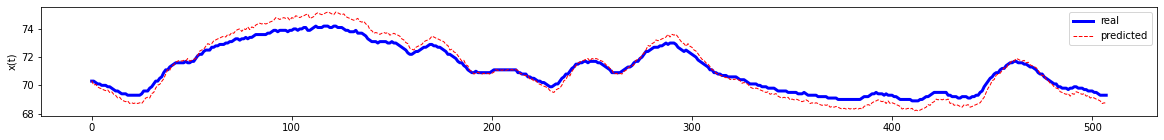

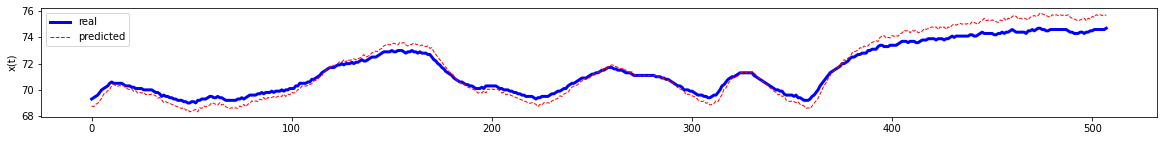

9012
0.952584981918335


In [9]:
# Hyperparameters
p   = 8           # size of branch and trunk ouput
n   = 4           # horizon window length
noi = 2           # number of inputs
H   = 512         # maximum window length

# Create Dataset and DataLoader objects
src_file_train = '0. Data/data_0.csv'
train_ds       = Data(src_file_train, n, H, noi)

src_file_test  = '0. Data/data_1.csv'
test_ds        = Data(src_file_test, n, H, noi)

# Create network
device = torch.device("cpu")
net = Net(n, p, noi).to(device)

# train model
lr         = 0.001
min_epochs = 500
max_epochs = 10000
patience   = 200
R2_train, R2_test = train(net, train_ds, test_ds, lr, min_epochs, max_epochs, patience)

# plot
plot(net, train_ds, (20,2))
plot(net, test_ds,  (20,2))

# best model
print(np.argmax(R2_test))
print(np.max(R2_test))

# save
PATH = '2. Saved model/DeepONet_HVAC.pt'
torch.save(net, PATH)